# Amazon food review analysis

###### Loading the data

In [64]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn import metrics
from nltk.stem.porter import PorterStemmer

In [65]:
con = sqlite3.connect('../amazon-fine-food-reviews/database.sqlite')
#con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.


In [66]:
def partition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'


In [67]:
score = data['Score']
pos_neg = score.map(partition)
data['Score'] = pos_neg


In [68]:
type(pos_neg)

pandas.core.series.Series

In [69]:
type(scores)

NameError: name 'scores' is not defined

In [70]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [71]:
#OR CAN DO THIS
#score = data['Score'].values
#pos_neg = np.array(list(map(partition,score)))
#data['Score'] = pos_neg

In [72]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Data cleaning

In [73]:
#same user gives same reviews for the same type of products

In [74]:
#So lets remove this duplication
data.shape

(525814, 10)

In [75]:
sort_data = data.sort_values('ProductId',axis= 0,ascending =True,inplace=False, kind='quicksort', na_position='last')
final= sort_data.drop_duplicates(subset = {"UserId","ProfileName","Time" ,"Text"},keep = 'first',inplace=False)
#subset: Subset takes a column or list of column label. It’s default value is none. After passing columns, it will consider them only for duplicates.
#keep: keep is to control how to consider duplicate value. It has only three distinct value and default is ‘first’.
#inplace = removes the row if it has duplicate here we want one to stay


In [76]:
final.shape

(364173, 10)

In [77]:
#Remove where helpfulness numerator is greater than denominator

In [78]:
final = final[final.HelpfulnessDenominator>=final.HelpfulnessNumerator]

In [79]:
final.shape

(364171, 10)

In [80]:
df_final=final['Score'].value_counts()

In [81]:
final.Score.values

array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'positive'], dtype=object)

In [82]:
val=(307061,57110)
rev=('positive','negative')

<BarContainer object of 2 artists>

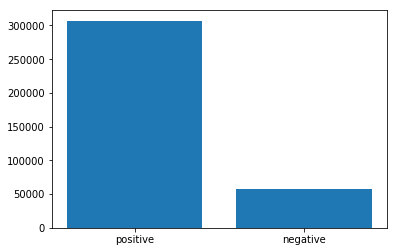

In [83]:
plt.bar(rev,val)

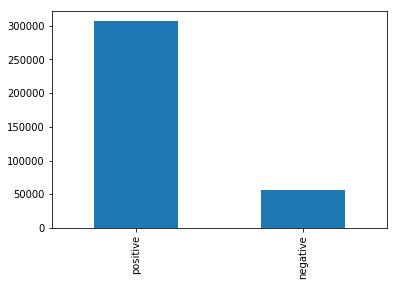

In [84]:
df_final.plot(kind = 'bar')

#preprocessing

In [85]:
#removing html tags with andular tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break
    i+= 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [86]:
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [87]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')#Compile a regular expression pattern into a regular expression object, 
    cleantext = re.sub('<.*?>' , ' ',sentence)
    return cleantext
def cleanpun(sen):
    clea1=re.sub(r'[?|!|\'|"|#]',r'',sen)
    cl2=re.sub(r'[.|,|)|(|\|/]',r' ',clea1)
    return cl2

In [88]:
sno.stem('tast')

'tast'

In [89]:
i=0
str1=''
final_string = []
all_pos = []
all_neg =[]
s=''
for sent in final['Text'].values:
    filtered_sen=[]
    sent = cleanhtml(sent)
    for w in sent.split():
        for cw in cleanpun(w).split():
             if((cw.isalpha()) & (len(cw)>2)):    
                if(cw.lower() not in stop):
                    s=(sno.stem(cw.lower())).encode('utf8')
                    filtered_sen.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_pos.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_neg.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
             else:
                continue 
                
    str1 = b" ".join(filtered_sen) #final string of cleaned words
    #filter_sen=['the','a','blah']
    #str1 is [the a blah]
    #so join function joins individual elemennts to one by a separator that is space here
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1           

In [90]:
final['cleantext']=final_string

In [91]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleantext
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [92]:
my_final=final[0:4000]

In [93]:
my_final.shape

(4000, 11)

In [94]:
my_final.Score.value_counts()

positive    3342
negative     658
Name: Score, dtype: int64

In [111]:
from sqlalchemy import create_engine

sql_engine = create_engine('sqlite:///final3.db', echo=False)#if you run this again the dataset sixe increase by 4000 so your final3.db will be 8000 on running again it becomes 12000 and so on
connection = sql_engine.raw_connection()
my_final.to_sql('reviews', connection,index=False, if_exists='append')

In [112]:
con = sqlite3.connect('final3.db')#finaldb of folder D:\ML LEARN\Applied AI Course\17 - Predict Amazon Food Reviews Rating

In [114]:
final_db_data = pd.read_sql_query("""SELECT * FROM reviews""", con) 
final_db_data.head()
final_db_data.Score.value_counts()

positive    3342
negative     658
Name: Score, dtype: int64

In [115]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_db_data['cleantext'].values)

In [116]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [117]:
final_counts

<4000x9492 sparse matrix of type '<class 'numpy.int64'>'
	with 143235 stored elements in Compressed Sparse Row format>

In [118]:
final_bow=final_counts.toarray()

In [119]:
final_bow.shape

(4000, 9492)

In [120]:
final_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [121]:
final_counts.shape

(4000, 9492)

In [122]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_bow)
print(standardized_data.shape)

c:\users\trusha\python\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(4000, 9492)


c:\users\trusha\python\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [123]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
